# 1 快速 tokenizer 的特殊能力

慢速 tokenizer 是在 🤗 Transformers 库中用 Python 编写的，而快速版本是由 🤗 Tokenizers 提供的，它们是用 Rust 编写的。

除了它们的并行化能力之外，快速 tokenizer 的关键功能是它们始终跟踪最终 token 相对于的原始文本的映射——我们称之为 偏移映射（offset mapping） 。这反过来又解锁了如将每个词映射到它生成的 token，或者将原始文本的每个字符映射到它所在的 token 等功能。

In [1]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
example = "My name is Sylvain and I work at Hugging Face in Brooklyn."
encoding = tokenizer(example)
print(type(encoding))

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

<class 'transformers.tokenization_utils_base.BatchEncoding'>


由于 AutoTokenizer 类默认选择快速 tokenizer 因此我们可以使用 BatchEncoding 对象提供的附加方法。我们有两种方法来检查我们的 tokenizer 是快速的还是慢速的。我们可以检查 tokenizer 的 is_fast 属性：

In [2]:
tokenizer.is_fast

True

首先，我们可以直接得到Ttokenization 之前的单词而无需将 ID 转换回单词：

In [3]:
encoding.tokens()

['[CLS]',
 'My',
 'name',
 'is',
 'S',
 '##yl',
 '##va',
 '##in',
 'and',
 'I',
 'work',
 'at',
 'Hu',
 '##gging',
 'Face',
 'in',
 'Brooklyn',
 '.',
 '[SEP]']

在这种情况下，索引 5 处的 token 是 ##yl ，它是原始句子中“Sylvain”一词的一部分。我们也可以使用 word_ids() 方法来获取每个 token 原始单词的索引：

In [4]:
encoding.word_ids()

[None, 0, 1, 2, 3, 3, 3, 3, 4, 5, 6, 7, 8, 8, 9, 10, 11, 12, None]

我们可以看到 tokenizer 的特殊 token [CLS] 和 [SEP] 被映射到 None ，然后每个 token 都映射到它来源的单词。这对于确定一个 token 是否在单词的开头或两个 token 是否在同一个单词中特别有用。

词的概念是复杂的。例如，“I’ll”（“I will”的缩写）算作一个词还是两个词？这实际上取决于 tokenizer 和它采用的预分词操作。有些 tokenizer 只在空格处分割，所以它们会把这个看作是一个词。有些其他 tokenizer 在空格的基础之上还使用标点，所以会认为它是两个词。

✏️ 试试看！从 bert base cased 和 roberta base checkpoint 创建一个 tokenizer 并用它们对“81s”进行分词。你观察到了什么？这些词的 ID 是什么？

In [6]:
bert_tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
roberta_tokenizer = AutoTokenizer.from_pretrained("roberta-base")

txt = "81s"
bert_encoding = bert_tokenizer(txt)
roberta_encoding = roberta_tokenizer(txt)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [8]:
bert_encoding.tokens(), roberta_encoding.tokens()

(['[CLS]', '81', '##s', '[SEP]'], ['<s>', '81', 's', '</s>'])

有以下区别：

1. 特殊标记：

  - BERT 使用 `[CLS]`（序列开始）和 `[SEP]`（序列结束）作为特殊标记
  - RoBERTa 使用 `<s>`（序列开始）和 `</s>`（序列结束）

2. 分词粒度差异：
  - BERT 的 WordPiece 算法在处理“81s”时，认为 s 是 81 的后缀（因此加 ##）
  - RoBERTa 的 BPE 算法直接将 s 视为独立字符，处理更简洁

同样，我们还有一个 sentence_ids() 方法，可以用它把一个 token 映射到它原始的句子（尽管在这种情况下，tokenizer 返回的 token_type_ids也可以为我们提供相同的信息）。

最后，我们可以通过 word_to_chars() 或 token_to_chars() 和 char_to_word() 或 char_to_token() 方法，将任何词或 token 映射到原始文本中的字符，反之亦然。例如， word_ids() 方法告诉我们 ##yl 是索引 3 处单词的一部分，但它是句子中的哪个单词？我们可以这样找出来：

In [13]:
st, ed = encoding.word_to_chars(3)
example[st:ed]

'Sylvain'

In [17]:
st, ed = encoding.token_to_chars(3)
example[st:ed]

'is'

In [22]:
encoding.char_to_word(1)

0

---

# 2 token-classification 管道内部流程

在 第一章 我们初次尝试实现命名实体识别（NER）——该任务是确定文本的哪些部分对应于人名、地名或组织名等实体——当时是使用🤗 Transformers 的 pipeline() 函数实现的。

然后，在 第二章 ，我们看到一个管道如何将获取原始文本到预测结果的三个阶段整合在一起：tokenize、通过模型处理输入和后处理。

token-classification 管道中的前两步与其他任何管道中的步骤相同。

## 2.1 使用管道获得基本结果

In [23]:
from transformers import pipeline
token_classifier = pipeline("token-classification")
token_classifier("My name is Sylvain and I work at Hugging Face in Brooklyn.")

No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english and revision 4c53496 (https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/998 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json:   0%|          | 0.00/60.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

Device set to use cpu


[{'entity': 'I-PER',
  'score': np.float32(0.99938285),
  'index': 4,
  'word': 'S',
  'start': 11,
  'end': 12},
 {'entity': 'I-PER',
  'score': np.float32(0.99815494),
  'index': 5,
  'word': '##yl',
  'start': 12,
  'end': 14},
 {'entity': 'I-PER',
  'score': np.float32(0.99590707),
  'index': 6,
  'word': '##va',
  'start': 14,
  'end': 16},
 {'entity': 'I-PER',
  'score': np.float32(0.99923277),
  'index': 7,
  'word': '##in',
  'start': 16,
  'end': 18},
 {'entity': 'I-ORG',
  'score': np.float32(0.9738931),
  'index': 12,
  'word': 'Hu',
  'start': 33,
  'end': 35},
 {'entity': 'I-ORG',
  'score': np.float32(0.976115),
  'index': 13,
  'word': '##gging',
  'start': 35,
  'end': 40},
 {'entity': 'I-ORG',
  'score': np.float32(0.9887976),
  'index': 14,
  'word': 'Face',
  'start': 41,
  'end': 45},
 {'entity': 'I-LOC',
  'score': np.float32(0.9932106),
  'index': 16,
  'word': 'Brooklyn',
  'start': 49,
  'end': 57}]

模型正确地识别出：“Sylvain”是一个人，“Hugging Face”是一个组织，以及“Brooklyn”是一个地点。我们也可以让管道将同一实体的 token 组合在一起：

In [24]:
token_classifier = pipeline("token-classification", aggregation_strategy="simple")
token_classifier("My name is Sylvain and I work at Hugging Face in Brooklyn.")

No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english and revision 4c53496 (https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


[{'entity_group': 'PER',
  'score': np.float32(0.9981694),
  'word': 'Sylvain',
  'start': 11,
  'end': 18},
 {'entity_group': 'ORG',
  'score': np.float32(0.9796019),
  'word': 'Hugging Face',
  'start': 33,
  'end': 45},
 {'entity_group': 'LOC',
  'score': np.float32(0.9932106),
  'word': 'Brooklyn',
  'start': 49,
  'end': 57}]

选择不同的 aggregation_strategy 可以更改每个分组实体计算的策略。对于 simple 策略，最终的分数就是给定实体中每个 token 的分数的平均值：例如，“Sylvain”的分数是我们在前一个例子中看到的 token S ， ##yl ， ##va ，和 ##in 的分数的平均值。其他可用的策略包括：

- “first”，其中每个实体的分数是该实体的第一个 token 的分数（因此对于“Sylvain”，分数将是 0.993828，这是“S”的分数）
- “max”，其中每个实体的分数是该实体中 token 的最大分数（因此对于“Hugging Face”，分数将是 0.98879766，即“Face”的分数）
- “average”，其中每个实体的分数是组成该实体的单词分数的平均值（因此对于“Sylvain”，与“simple”策略相同，但“Hugging Face”的得分将是 0.9819，这是“Hugging”的分数 0.975 和“Face”的分数 0.98879 的平均值）

现在让我们看看如何在不使用 pipeline() 函数的情况下获得这些结果！

## 2.2 从输入到预测

首先，我们需要将我们的输入进行 tokenization 并将其传递给模型。这个过程与 第二章 中的方法完全相同；我们使用 AutoXxx 类实例化 tokenizer 和模型，然后将我们的示例传递给它们：

In [25]:
from transformers import AutoTokenizer, AutoModelForTokenClassification

model_checkpoint = "dbmdz/bert-large-cased-finetuned-conll03-english"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = AutoModelForTokenClassification.from_pretrained(model_checkpoint)

example = "My name is Sylvain and I work at Hugging Face in Brooklyn."
inputs = tokenizer(example, return_tensors='pt')
outputs = model(**inputs)

Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [28]:
len(inputs.tokens())

19

In [26]:
print(inputs["input_ids"].shape)
print(outputs.logits.shape)

torch.Size([1, 19])
torch.Size([1, 19, 9])


我们有一个包含 19 个 token 序列的 batch 和有 9 个不同的标签类型，所以模型的输出形状为 1 x 19 x 9。像文本分类管道一样，我们使用 softmax 函数将这些 logits 转化为概率，并取 argmax 来得到预测（请注意，我们可以在 logits 上直接算取 argmax，因为 softmax 不会改变顺序）：

In [36]:
import torch
probabilities = torch.nn.functional.softmax(outputs.logits, dim=-1)[0].tolist()
predictions = outputs.logits.argmax(dim=-1)[0].tolist()
predictions

[0, 0, 0, 0, 4, 4, 4, 4, 0, 0, 0, 0, 6, 6, 6, 0, 8, 0, 0]

model.config.id2label 属性包含索引到标签的映射，我们可以用它来将预测转化为标签：

In [37]:
model.config.id2label

{0: 'O',
 1: 'B-MISC',
 2: 'I-MISC',
 3: 'B-PER',
 4: 'I-PER',
 5: 'B-ORG',
 6: 'I-ORG',
 7: 'B-LOC',
 8: 'I-LOC'}

如前所述，这里有 9 个标签： O 是不在任何实体中的 token 的标签（它代表“outside”），然后我们为每种类型的实体（杂项、人员、组织和位置）提供两个标签：标签 B-XXX 表示 token 在实体 XXX 的开头，标签 I-XXX 表示 token 在实体 XXX 内部。

例如，在当前的例子，我们期望我们的模型将 token S 分类为 B-PER （人物实体的开始），并且将 token ##yl ， ##va 和 ##in 分类为 I-PER （人物实体的内部）

你可能会觉得上面模型的输出是错误的，因为它给所有这四个 token 都标上了 I-PER 标签，但这样理解并不完全正确。对于 B- 和 I- 标签，实际上有两种格式：IOB1 和 IOB2。

我们介绍的是 IOB2 格式（如下图所示的粉色），而在 IOB1 格式（蓝色）中，以 B- 开头的标签只用于分隔同一类型的两个相邻实体。我们正在使用的模型在使用该格式的数据集上进行了微调，这就是为什么它将 S token 标上了 I-PER 标签的原因。

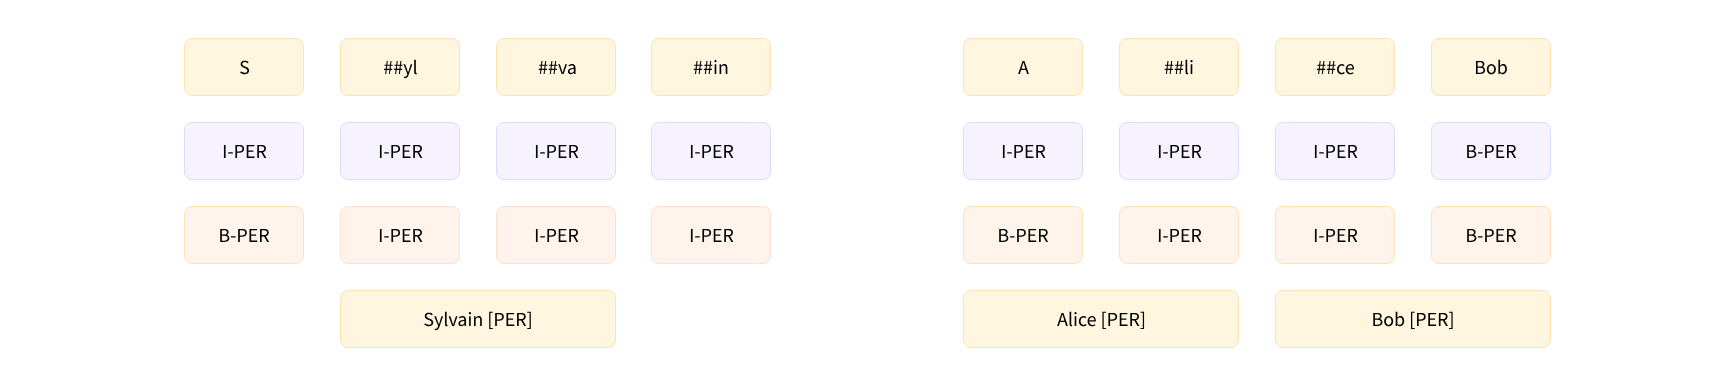

有了这个映射字典，我们就可以几乎完全复现管道的结果 —— 我们只需要获取每个没有被分类为 O 的 token 的得分和标签：

In [42]:
results = []
tokens = inputs.tokens()

for i, pred in enumerate(predictions):
  label = model.config.id2label[pred]
  if label != 'O':
    results.append({
        'entity': label,
        'score': probabilities[i][pred],
        'word': tokens[i]
    })
results

[{'entity': 'I-PER', 'score': 0.9993828535079956, 'word': 'S'},
 {'entity': 'I-PER', 'score': 0.9981548190116882, 'word': '##yl'},
 {'entity': 'I-PER', 'score': 0.995907187461853, 'word': '##va'},
 {'entity': 'I-PER', 'score': 0.9992327690124512, 'word': '##in'},
 {'entity': 'I-ORG', 'score': 0.9738931059837341, 'word': 'Hu'},
 {'entity': 'I-ORG', 'score': 0.9761149883270264, 'word': '##gging'},
 {'entity': 'I-ORG', 'score': 0.9887974858283997, 'word': 'Face'},
 {'entity': 'I-LOC', 'score': 0.99321049451828, 'word': 'Brooklyn'}]

这与我们之前的结果非常相似，但有一点不同：pipeline 还给我们提供了每个实体在原始句子中的 start 和 end 的信息。

如果要复现这个特性，这就是我们的偏移映射要发挥作用的地方。要获得偏移量，我们只需要在使用 tokenizer 器时设置 `return_offsets_mapping=True` ：

In [45]:
inputs_with_offsets = tokenizer(example, return_offsets_mapping=True)
inputs_with_offsets.tokens(), inputs_with_offsets["offset_mapping"]

(['[CLS]',
  'My',
  'name',
  'is',
  'S',
  '##yl',
  '##va',
  '##in',
  'and',
  'I',
  'work',
  'at',
  'Hu',
  '##gging',
  'Face',
  'in',
  'Brooklyn',
  '.',
  '[SEP]'],
 [(0, 0),
  (0, 2),
  (3, 7),
  (8, 10),
  (11, 12),
  (12, 14),
  (14, 16),
  (16, 18),
  (19, 22),
  (23, 24),
  (25, 29),
  (30, 32),
  (33, 35),
  (35, 40),
  (41, 45),
  (46, 48),
  (49, 57),
  (57, 58),
  (0, 0)])

In [49]:
example[33:35]

'Hu'

使用这个，我们现在可以完成之前的想法：

In [48]:
results = []
inputs_with_offsets = tokenizer(example, return_offsets_mapping=True)
tokens = inputs_with_offsets.tokens()
offsets = inputs_with_offsets["offset_mapping"]

for idx, pred in enumerate(predictions):
    label = model.config.id2label[pred]
    if label != "O":
        start, end = offsets[idx]
        results.append({
            "entity": label,
            "score": probabilities[idx][pred],
            "word": tokens[idx],
            "start": start,
            "end": end,
        })

results

[{'entity': 'I-PER',
  'score': 0.9993828535079956,
  'word': 'S',
  'start': 11,
  'end': 12},
 {'entity': 'I-PER',
  'score': 0.9981548190116882,
  'word': '##yl',
  'start': 12,
  'end': 14},
 {'entity': 'I-PER',
  'score': 0.995907187461853,
  'word': '##va',
  'start': 14,
  'end': 16},
 {'entity': 'I-PER',
  'score': 0.9992327690124512,
  'word': '##in',
  'start': 16,
  'end': 18},
 {'entity': 'I-ORG',
  'score': 0.9738931059837341,
  'word': 'Hu',
  'start': 33,
  'end': 35},
 {'entity': 'I-ORG',
  'score': 0.9761149883270264,
  'word': '##gging',
  'start': 35,
  'end': 40},
 {'entity': 'I-ORG',
  'score': 0.9887974858283997,
  'word': 'Face',
  'start': 41,
  'end': 45},
 {'entity': 'I-LOC',
  'score': 0.99321049451828,
  'word': 'Brooklyn',
  'start': 49,
  'end': 57}]

## 2.3 实体分组

使用偏移来确定每个实体的开始和结束的索引很方便，但这并不是它唯一的用法。当我们希望将实体分组在一起时，偏移映射将为我们省去很多复杂的代码。

例如，如果我们想将 Hu 、 ##gging 和 Face token 分组在一起，我们可以制定特殊规则，比如说前两个应该在去除 ## 的同时连在一起， Face 应该在不以 ## 开头的情况下增加空格 — 但这些规则只适用于这种特定类型的分词器。

为了编写处理预测结果并分组实体的代码，我们将对连续标记为 I-XXX 的实体进行分组，因为只有实体的第一个 token 可以被标记为 B-XXX 或 I-XXX ，因此，当我们遇到实体 O 、新类型的实体或 B-XXX 时，我们就可以停止聚合同一类型实体。

In [50]:
import numpy as np

results = []
inputs_with_offsets = tokenizer(example, return_offsets_mapping=True)
tokens = inputs_with_offsets.tokens()
offsets = inputs_with_offsets["offset_mapping"]

idx = 0
while idx < len(predictions):
    pred = predictions[idx]
    label = model.config.id2label[pred]
    if label != "O":
        # 删除 B- 或者 I-
        label = label[2:]
        start, _ = offsets[idx]

        # 获取所有标有 I 标签的token
        all_scores = []
        while (
            idx < len(predictions)
            and model.config.id2label[predictions[idx]] == f"I-{label}"
        ):
            all_scores.append(probabilities[idx][pred])
            _, end = offsets[idx]
            idx += 1

        # 分数是该分组实体中所有token分数的平均值
        score = np.mean(all_scores).item()
        word = example[start:end]
        results.append(
            {
                "entity_group": label,
                "score": score,
                "word": word,
                "start": start,
                "end": end,
            }
        )
    idx += 1

results

[{'entity_group': 'PER',
  'score': 0.998169407248497,
  'word': 'Sylvain',
  'start': 11,
  'end': 18},
 {'entity_group': 'ORG',
  'score': 0.9796018600463867,
  'word': 'Hugging Face',
  'start': 33,
  'end': 45},
 {'entity_group': 'LOC',
  'score': 0.99321049451828,
  'word': 'Brooklyn',
  'start': 49,
  'end': 57}]

In [59]:
for i in range(len(tokens)):
  print(tokens[i], ":", model.config.id2label[predictions[i]])

[CLS] : O
My : O
name : O
is : O
S : I-PER
##yl : I-PER
##va : I-PER
##in : I-PER
and : O
I : O
work : O
at : O
Hu : I-ORG
##gging : I-ORG
Face : I-ORG
in : O
Brooklyn : I-LOC
. : O
[SEP] : O
